# The Task

Building a machine learning model to **predict car price** using all of the provided features.

# The Data

a modified version of the car price [dataset](https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv) from [Kaggle](https://www.kaggle.com/datasets/hellbuoy/car-price-prediction).

In [1]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


In [2]:
## Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 42
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

## set pandas to display more columns
pd.set_option('display.max_columns',50)

In [3]:
## Load in the student performance - portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSnWFRczgXa0AyKkbioX5Roq60X7GTAFilKtpFuAmyGi9uPMwdb51Jo-cpupDyjhT0EVqcNRJPINZ5b/pub?output=csv"
df = pd.read_csv(url)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltype          205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumber        205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheel        205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    int64  
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## Preprocessing the data

In [4]:
# train test split
## Make x and y variables
y = df['price']
X = df.drop(columns=['price'])
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
90,1,diesel,std,two,sedan,fwd,front,94.5,165.3,63.8,54.5,2017,ohc,4,103,idi,2.99,3.47,21.9,55,4800,45,50
173,-1,gas,std,four,sedan,fwd,front,102.4,175.6,66.5,54.9,2326,ohc,4,122,mpfi,3.31,3.54,8.7,92,4200,29,34
93,1,gas,std,four,wagon,fwd,front,94.5,170.2,63.8,53.5,2024,ohc,4,97,2bbl,3.15,3.29,9.4,69,5200,31,37
5,2,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,5,136,mpfi,3.19,3.40,8.5,110,5500,19,25
167,2,gas,std,two,hardtop,rwd,front,98.4,176.2,65.6,52.0,2540,ohc,4,146,mpfi,3.62,3.50,9.3,116,4800,24,30


In [5]:
# Preprocessing
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')

## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')

## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x128f77220>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x128f77280>)],
                  verbose_feature_names_out=False)

In [6]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'cylindernumber', 'enginesize', 'boreratio',
       'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg',
       'highwaympg', 'fueltype_diesel', 'fueltype_gas', 'aspiration_std',
       'aspiration_turbo', 'doornumber_four', 'doornumber_two',
       'carbody_convertible', 'carbody_hardtop', 'carbody_hatchback',
       'carbody_sedan', 'carbody_wagon', 'drivewheel_4wd',
       'drivewheel_fwd', 'drivewheel_rwd', 'enginelocation_front',
       'enginelocation_rear', 'enginetype_dohc', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor', 'fuelsystem_1bbl',
       'fuelsystem_2bbl', 'fuelsystem_4bbl', 'fuelsystem_idi',
       'fuelsystem_mpfi', 'fuelsystem_spdi', 'fuelsystem_spfi'],
      dtype=object)

In [7]:
# Remaking Our X_train and X_test as DataFrames with the New Feature Names
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_train_df.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
90,1.0,94.5,165.3,63.8,54.5,2017.0,4.0,103.0,2.99,3.47,21.9,55.0,4800.0,45.0,50.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
173,-1.0,102.4,175.6,66.5,54.9,2326.0,4.0,122.0,3.31,3.54,8.7,92.0,4200.0,29.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
93,1.0,94.5,170.2,63.8,53.5,2024.0,4.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2.0,99.8,177.3,66.3,53.1,2507.0,5.0,136.0,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
167,2.0,98.4,176.2,65.6,52.0,2540.0,4.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,fueltype_diesel,fueltype_gas,aspiration_std,aspiration_turbo,doornumber_four,doornumber_two,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation_front,enginelocation_rear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
15,0.0,103.5,189.0,66.9,55.7,3230.0,6.0,209.0,3.62,3.39,8.00,182.0,5400.0,16.0,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,99.5,178.2,67.9,52.0,3053.0,5.0,131.0,3.13,3.40,7.00,160.0,5500.0,16.0,22.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
100,0.0,97.2,173.4,65.2,54.7,2302.0,4.0,120.0,3.33,3.47,8.50,97.0,5200.0,27.0,34.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
132,3.0,99.1,186.6,66.5,56.1,2658.0,4.0,121.0,3.54,3.07,9.31,110.0,5250.0,21.0,28.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
68,-1.0,110.0,190.9,70.3,58.7,3750.0,5.0,183.0,3.58,3.64,21.50,123.0,4350.0,22.0,25.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
## confirm the first 5 rows index in y_test matches X_test_df
y_test.head()

104    16
284     6
579     9
540    11
309    14
Name: G3, dtype: int64

In [10]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [11]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.98	RMSE= 0.52
Test Data:	R^2= 0.83	RMSE= 1.26


# Extracting Feature Importances


In [12]:
reg.feature_importances_

array([9.06096804e-03, 4.27750617e-03, 3.98699965e-03, 7.00472751e-03,
       2.25626018e-03, 3.51399028e-03, 2.49268280e-03, 7.28098375e-03,
       5.16832208e-03, 7.96493073e-03, 3.65255869e-03, 3.45093237e-03,
       2.12456262e-02, 1.43357641e-02, 8.49691456e-01, 1.50552537e-03,
       1.34049006e-03, 8.01336123e-04, 2.00642049e-03, 9.16339891e-04,
       1.07877854e-03, 7.07605663e-04, 9.56989326e-04, 5.25321529e-04,
       3.57271546e-04, 7.24549353e-04, 4.69078763e-04, 1.72276703e-03,
       7.87754005e-04, 4.04612977e-03, 4.95701770e-04, 6.32101752e-04,
       2.02437914e-03, 2.64153718e-03, 2.88623322e-04, 1.66038340e-03,
       1.49827250e-03, 7.13793226e-03, 1.32903677e-03, 2.40072554e-03,
       1.19251978e-03, 6.59015769e-04, 1.29186344e-03, 1.17453508e-03,
       2.87137667e-03, 2.08767090e-03, 4.90905227e-04, 2.05326973e-04,
       6.07999604e-04, 6.08562065e-04, 1.09193794e-03, 1.09819114e-03,
       3.43745866e-04, 3.14073124e-04, 3.66951986e-04, 5.29971880e-04,
      

In [13]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

58
58


True

# Saving the importances as a Pandas Series


In [14]:
## Saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

age                  0.009061
Medu                 0.004278
Fedu                 0.003987
traveltime           0.007005
studytime            0.002256
failures             0.003514
famrel               0.002493
freetime             0.007281
goout                0.005168
Dalc                 0.007965
Walc                 0.003653
health               0.003451
absences             0.021246
G1                   0.014336
G2                   0.849691
school_GP            0.001506
school_MS            0.001340
sex_F                0.000801
sex_M                0.002006
address_R            0.000916
address_U            0.001079
famsize_GT3          0.000708
famsize_LE3          0.000957
Pstatus_A            0.000525
Pstatus_T            0.000357
Mjob_at_home         0.000725
Mjob_health          0.000469
Mjob_other           0.001723
Mjob_services        0.000788
Mjob_teacher         0.004046
Fjob_at_home         0.000496
Fjob_health          0.000632
Fjob_other           0.002024
Fjob_servi

As you can see, we now have a value for each feature used by our model.

- the importances are all small values (below 1).
- the importances sum up to 1 overall.

In [15]:
importances.sum()

0.9999999999999999

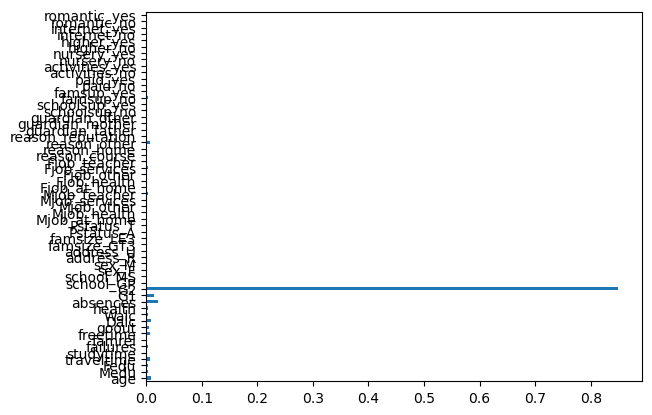

In [16]:
# plot importance
ax = importances.plot(kind='barh')
# its bad

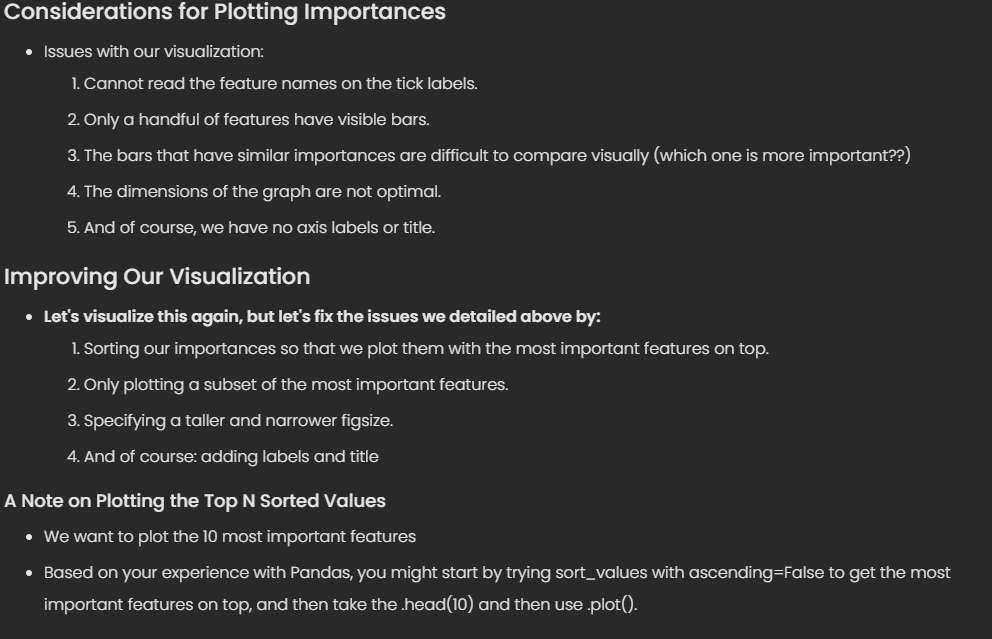

<Axes: >

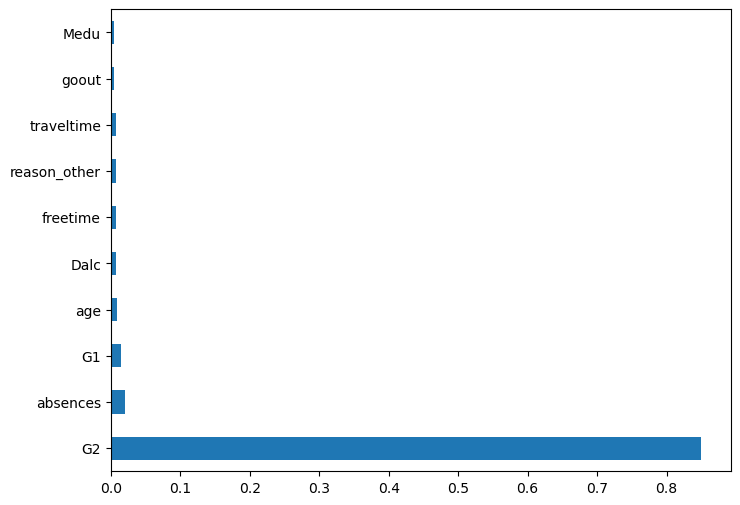

In [17]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)

## just keep the top 10 importances and plot
sorted_importance.head(10).plot(kind='barh',
                                   figsize=(8,6))

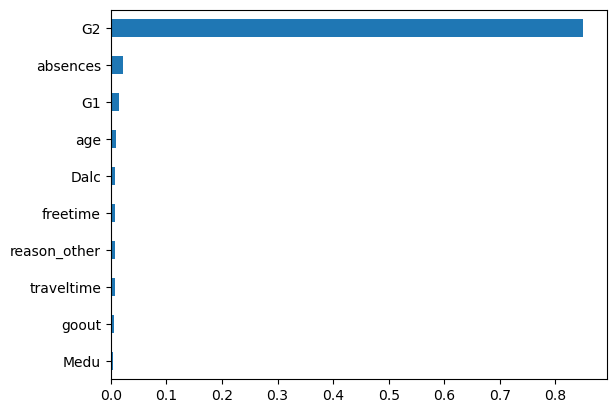

In [18]:
# make it upside down!
## Saving the feature importances sorted from smallest to largest (ascending=True)
sorted_importance = importances.sort_values()
## just keep the top 10 importances and plot (that are now at the bottom of our series)
ax = sorted_importance.tail(10).plot(kind='barh')

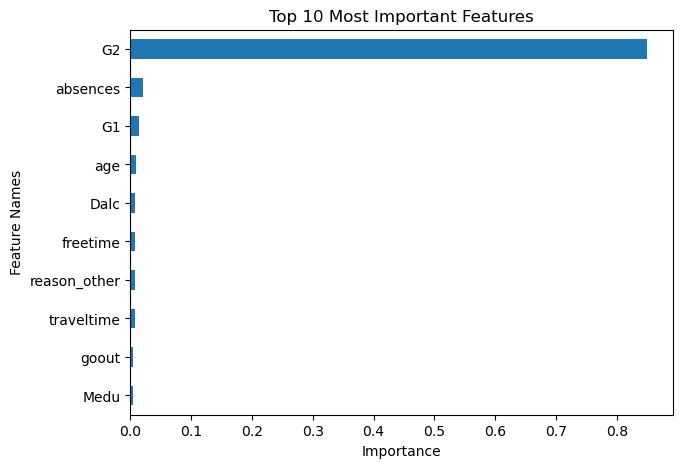

In [19]:
## plotting top 10 importances and adding more spice
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(7,5),
                                      )
ax.set(xlabel='Importance',
        ylabel='Feature Names',
        title='Top 10 Most Important Features');

# Note on saving Figures as a variables


In [20]:
# if only ax, nothing happened
ax

<Axes: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

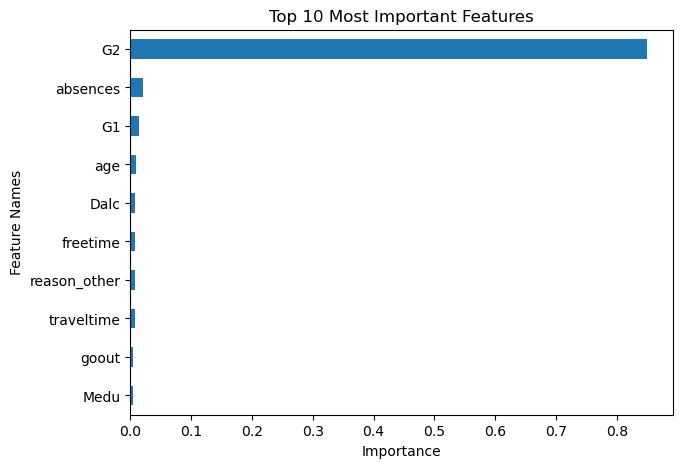

In [21]:
# to save the fig, two ways to do
## 1 use the ax.get_figure() method to extract it from our axis
## using the ax to get the fig
fig_ax = ax.get_figure()
fig_ax 

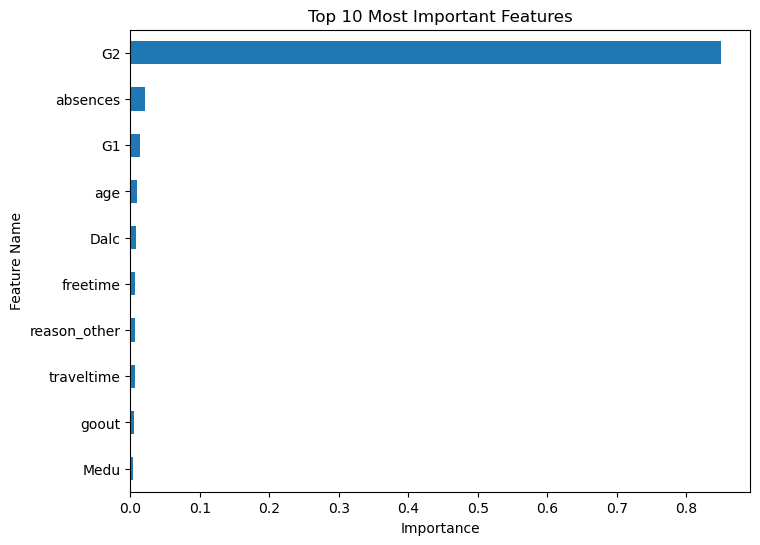

In [22]:
## 2 run a special matplotlib function in the same cell that we create graph. 
## The function is called plt.gcf() (get current figure)
## Using plt.gcf to get the fig
ax = sorted_importance.tail(10).plot(kind='barh',
                                    figsize=(8,6), xlabel='Importance',
                                    ylabel='Feature Name', 
                                    title='Top 10 Most Important Features')
fig_gcf = plt.gcf()

# Interpreting Feature Importance


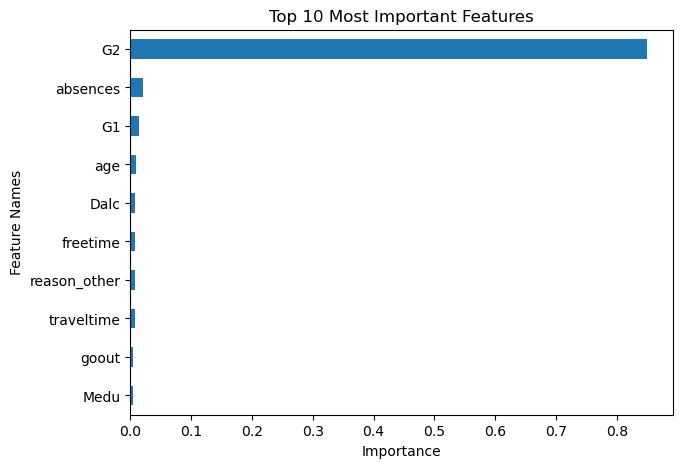

In [23]:
fig_ax

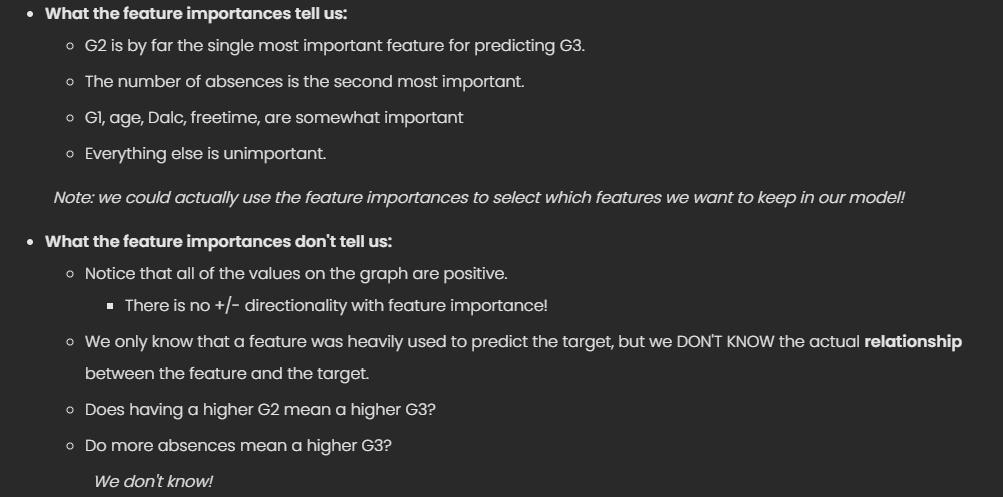

## Defining a Function for Feature Importance

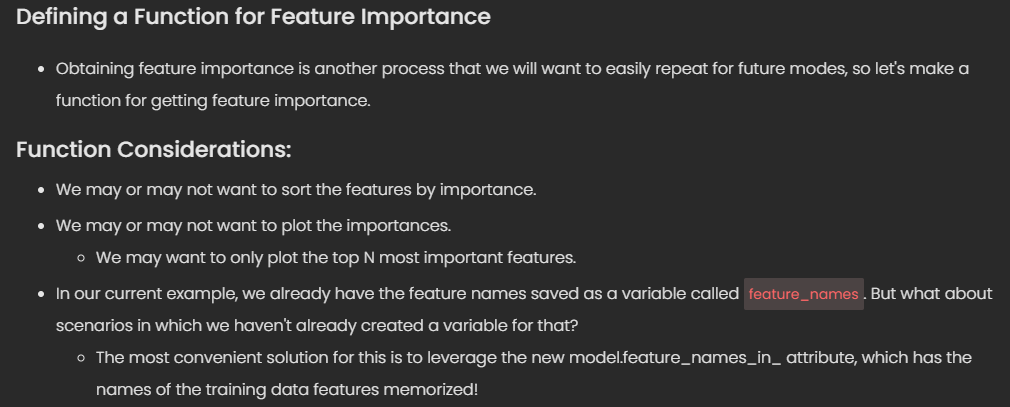

In [24]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [25]:
importances = get_importances(reg,sort=True,ascending=False)
importances

G2                   0.849691
absences             0.021246
G1                   0.014336
age                  0.009061
Dalc                 0.007965
freetime             0.007281
reason_other         0.007138
traveltime           0.007005
goout                0.005168
Medu                 0.004278
Mjob_teacher         0.004046
Fedu                 0.003987
Walc                 0.003653
failures             0.003514
health               0.003451
famsup_no            0.002871
Fjob_services        0.002642
famrel               0.002493
guardian_father      0.002401
studytime            0.002256
famsup_yes           0.002088
Fjob_other           0.002024
sex_M                0.002006
Mjob_other           0.001723
reason_course        0.001660
school_GP            0.001506
reason_home          0.001498
school_MS            0.001340
reason_reputation    0.001329
schoolsup_no         0.001292
guardian_mother      0.001193
schoolsup_yes        0.001175
nursery_yes          0.001098
nursery_no

In [26]:
# let's create a custom function to plot our importances:

def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

<Axes: title={'center': 'All Features - Ranked by Importance'}, xlabel='Importance', ylabel='Feature Names'>

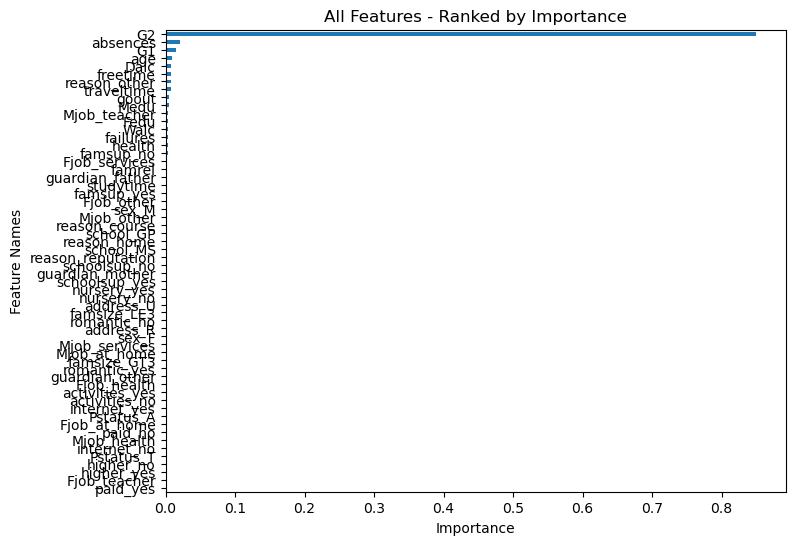

In [27]:
## testing our function
plot_importance(importances)

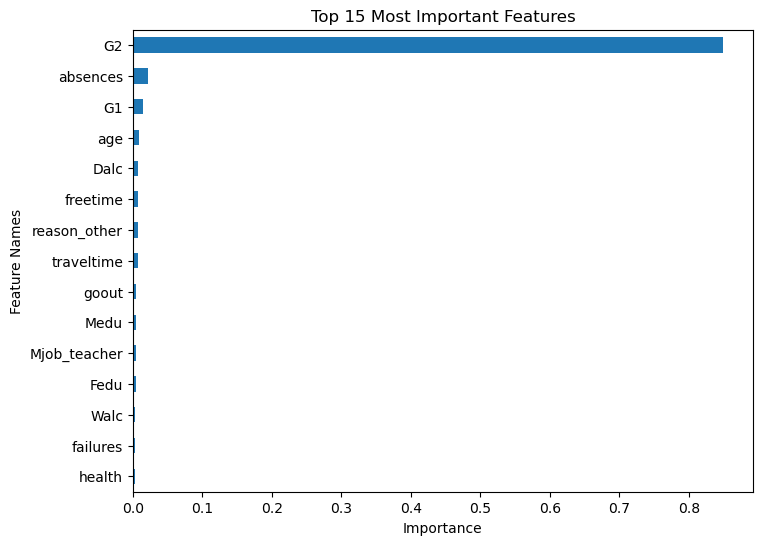

In [28]:
## lets make the plot better
## testing our function
importances = get_importances(reg,sort=True,ascending=False,
                              name="RandomForest Importances")
plot_importance(importances,top_n=15);

Training Data:	R^2= 0.98	RMSE= 0.52
Test Data:	R^2= 0.83	RMSE= 1.26


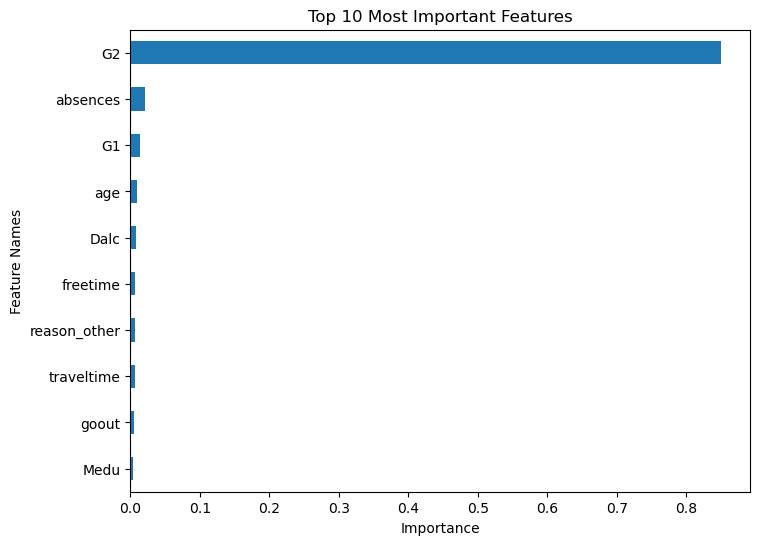

In [29]:
# Remaking Our Model - Using Our Functions
## fit random forest
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)
## Saving the feature importances
importances = get_importances(reg)
plot_importance(importances, top_n=10);

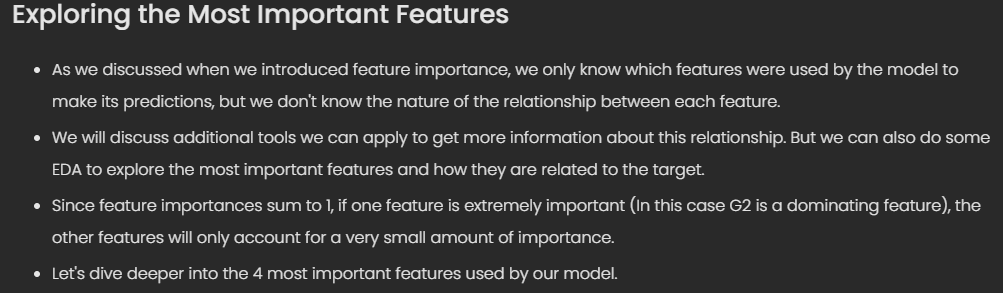

In [30]:
importances.sort_values(ascending=False).head(4)

G2          0.849691
absences    0.021246
G1          0.014336
age         0.009061
Name: Feature Importance, dtype: float64

In [31]:
#Before complete EDA, let's put DataFrame back together for plotting to include
#all train and test values and to ensure features are matched up with 
# the correct G3 score.
plot_train = pd.concat([X_train_df,y_train],axis=1)
plot_test = pd.concat([X_test_df,y_test],axis=1)
plot_df = pd.concat([plot_train, plot_test])
plot_df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,G3
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,13.0,12.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,13
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,13.0,12.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,12
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,10.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,10
547,16.0,4.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,1.0,2.0,0.0,10.0,11.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,11
604,18.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,2.0,1.0,2.0,2.0,2.0,9.0,10.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,17.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,1.0,3.0,0.0,13.0,13.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,14
454,16.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,4.0,3.0,9.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,8
56,15.0,4.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,15.0,14.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,15
203,17.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,3.0,1.0,5.0,3.0,6.0,9.0,9.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,10


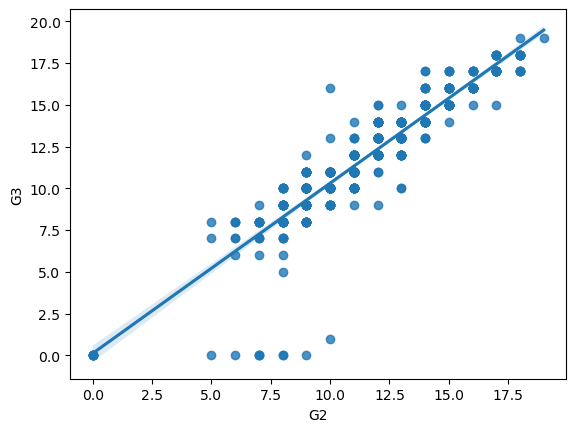

In [32]:
#between g2 and g3
sns.regplot(data=plot_df, x='G2',y='G3');

- We can see a very clear pattern between G2 and G3. Except for a few 0's, all of the other values show a very strong correlation between G2 and G3, which makes sense.
- How well you did in Portuguese last period is going to be a very good indicator of how well you do in Portuguese the next period.

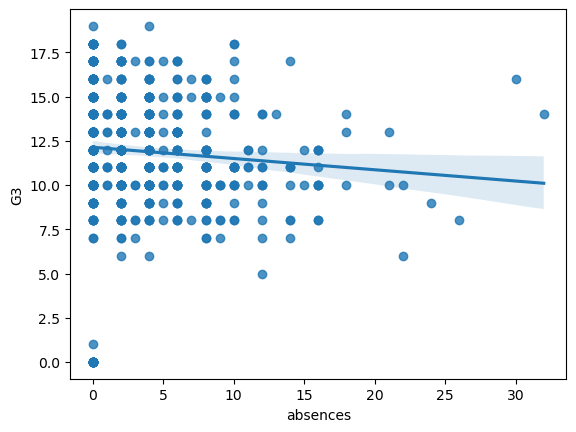

In [33]:
# between g3 and absences
sns.regplot(data=plot_df, x='absences',y='G3');

- Absences seem to have a relatively flat relationship when we view a linear regression line summarizing the relationship.
- Instead of a normal linear regression, we can apply a Lowess regression (Locally Weighted Smoothed Scatterplot). This provides us with a nonlinear curve summarizing the relationship over the length of the entire x-axis.

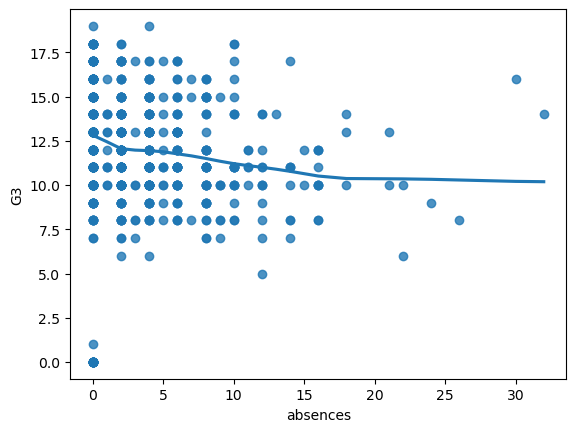

In [34]:
sns.regplot(data=plot_df, x='absences',y='G3', lowess=True);

<Axes: xlabel='G1', ylabel='G3'>

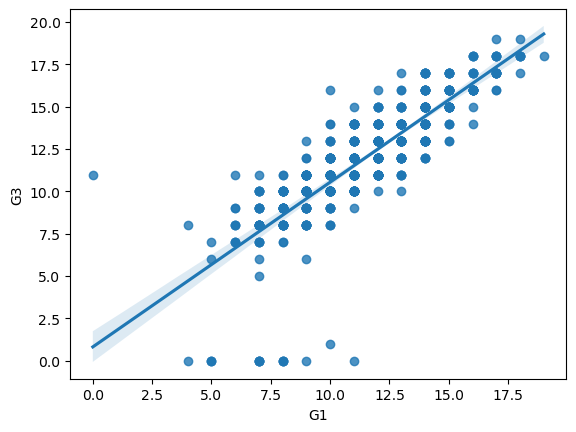

In [35]:
# g1 and g3
sns.regplot(data=plot_df, x='G1',y='G3')
# Not surprisingly G1, is also a strong predictor, like G2.

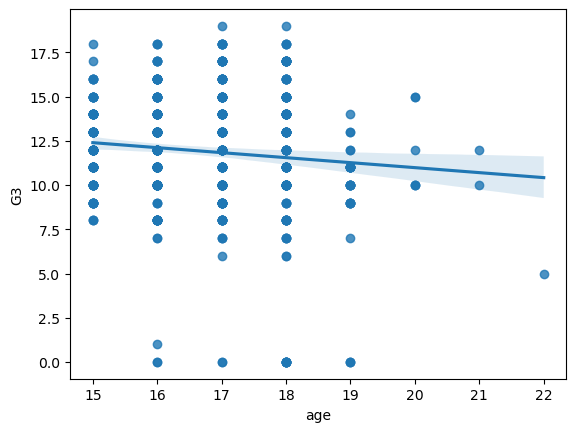

In [36]:
# age and g3
sns.regplot(data=plot_df, x='age',y='G3');
##  age has a more complicated and nonlinear relationship with our target.
## Let's visualize the Lowess scatterplot for this feature.

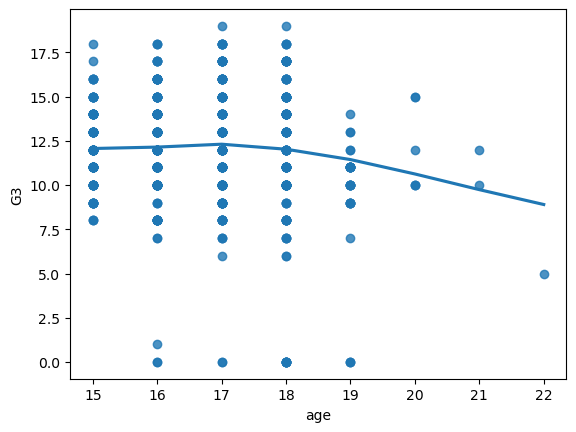

In [37]:
sns.regplot(data=plot_df, x='age',y='G3',lowess=True);

- It looks like the lowess scatterplot is showing us the same thing as our linear scatterplot: A minor downward trend as age increases.
- If we treat the ages as groups and visualize the average grade for each age, we may be able to see the pattern more clearly.

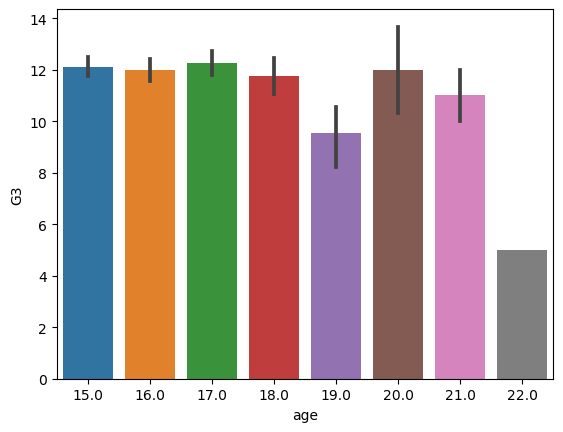

In [38]:
sns.barplot(data=plot_df, x='age',y='G3');

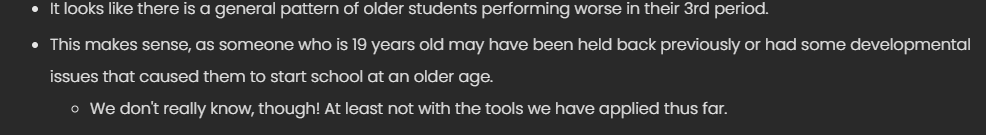

Now we create a swarmplot on top of our bar plot. A swarmplot is a scatterplot that separates the points so they do not overlap and each point can be seen. This is an advanced technique to provide us with a more detailed visualization.

<Axes: xlabel='age', ylabel='G3'>

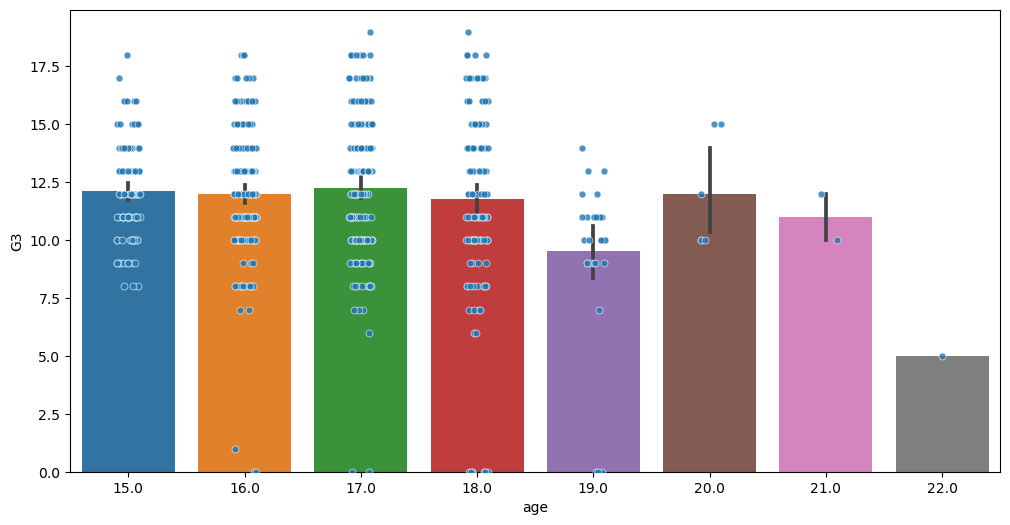

In [39]:
## adding a swarmplot to visualize each point
plt.figure(figsize=(12,6))
sns.stripplot(data=plot_df, x='age',y='G3',size=5,edgecolor='white',
              linewidth=0.5, alpha=.8);
sns.barplot(data=plot_df, x='age',y='G3')#,palette='dark');

In [40]:
# Plotting trees
example_tree =  reg.estimators_[0]
example_tree

DecisionTreeRegressor(max_features=1.0, random_state=1657633780)

In [41]:
evaluate_regression(example_tree,X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.88	RMSE= 1.16
Test Data:	R^2= 0.71	RMSE= 1.62


D:\Anaconda\envs\dojo-env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\Anaconda\envs\dojo-env\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [42]:
example_tree.get_depth()

12

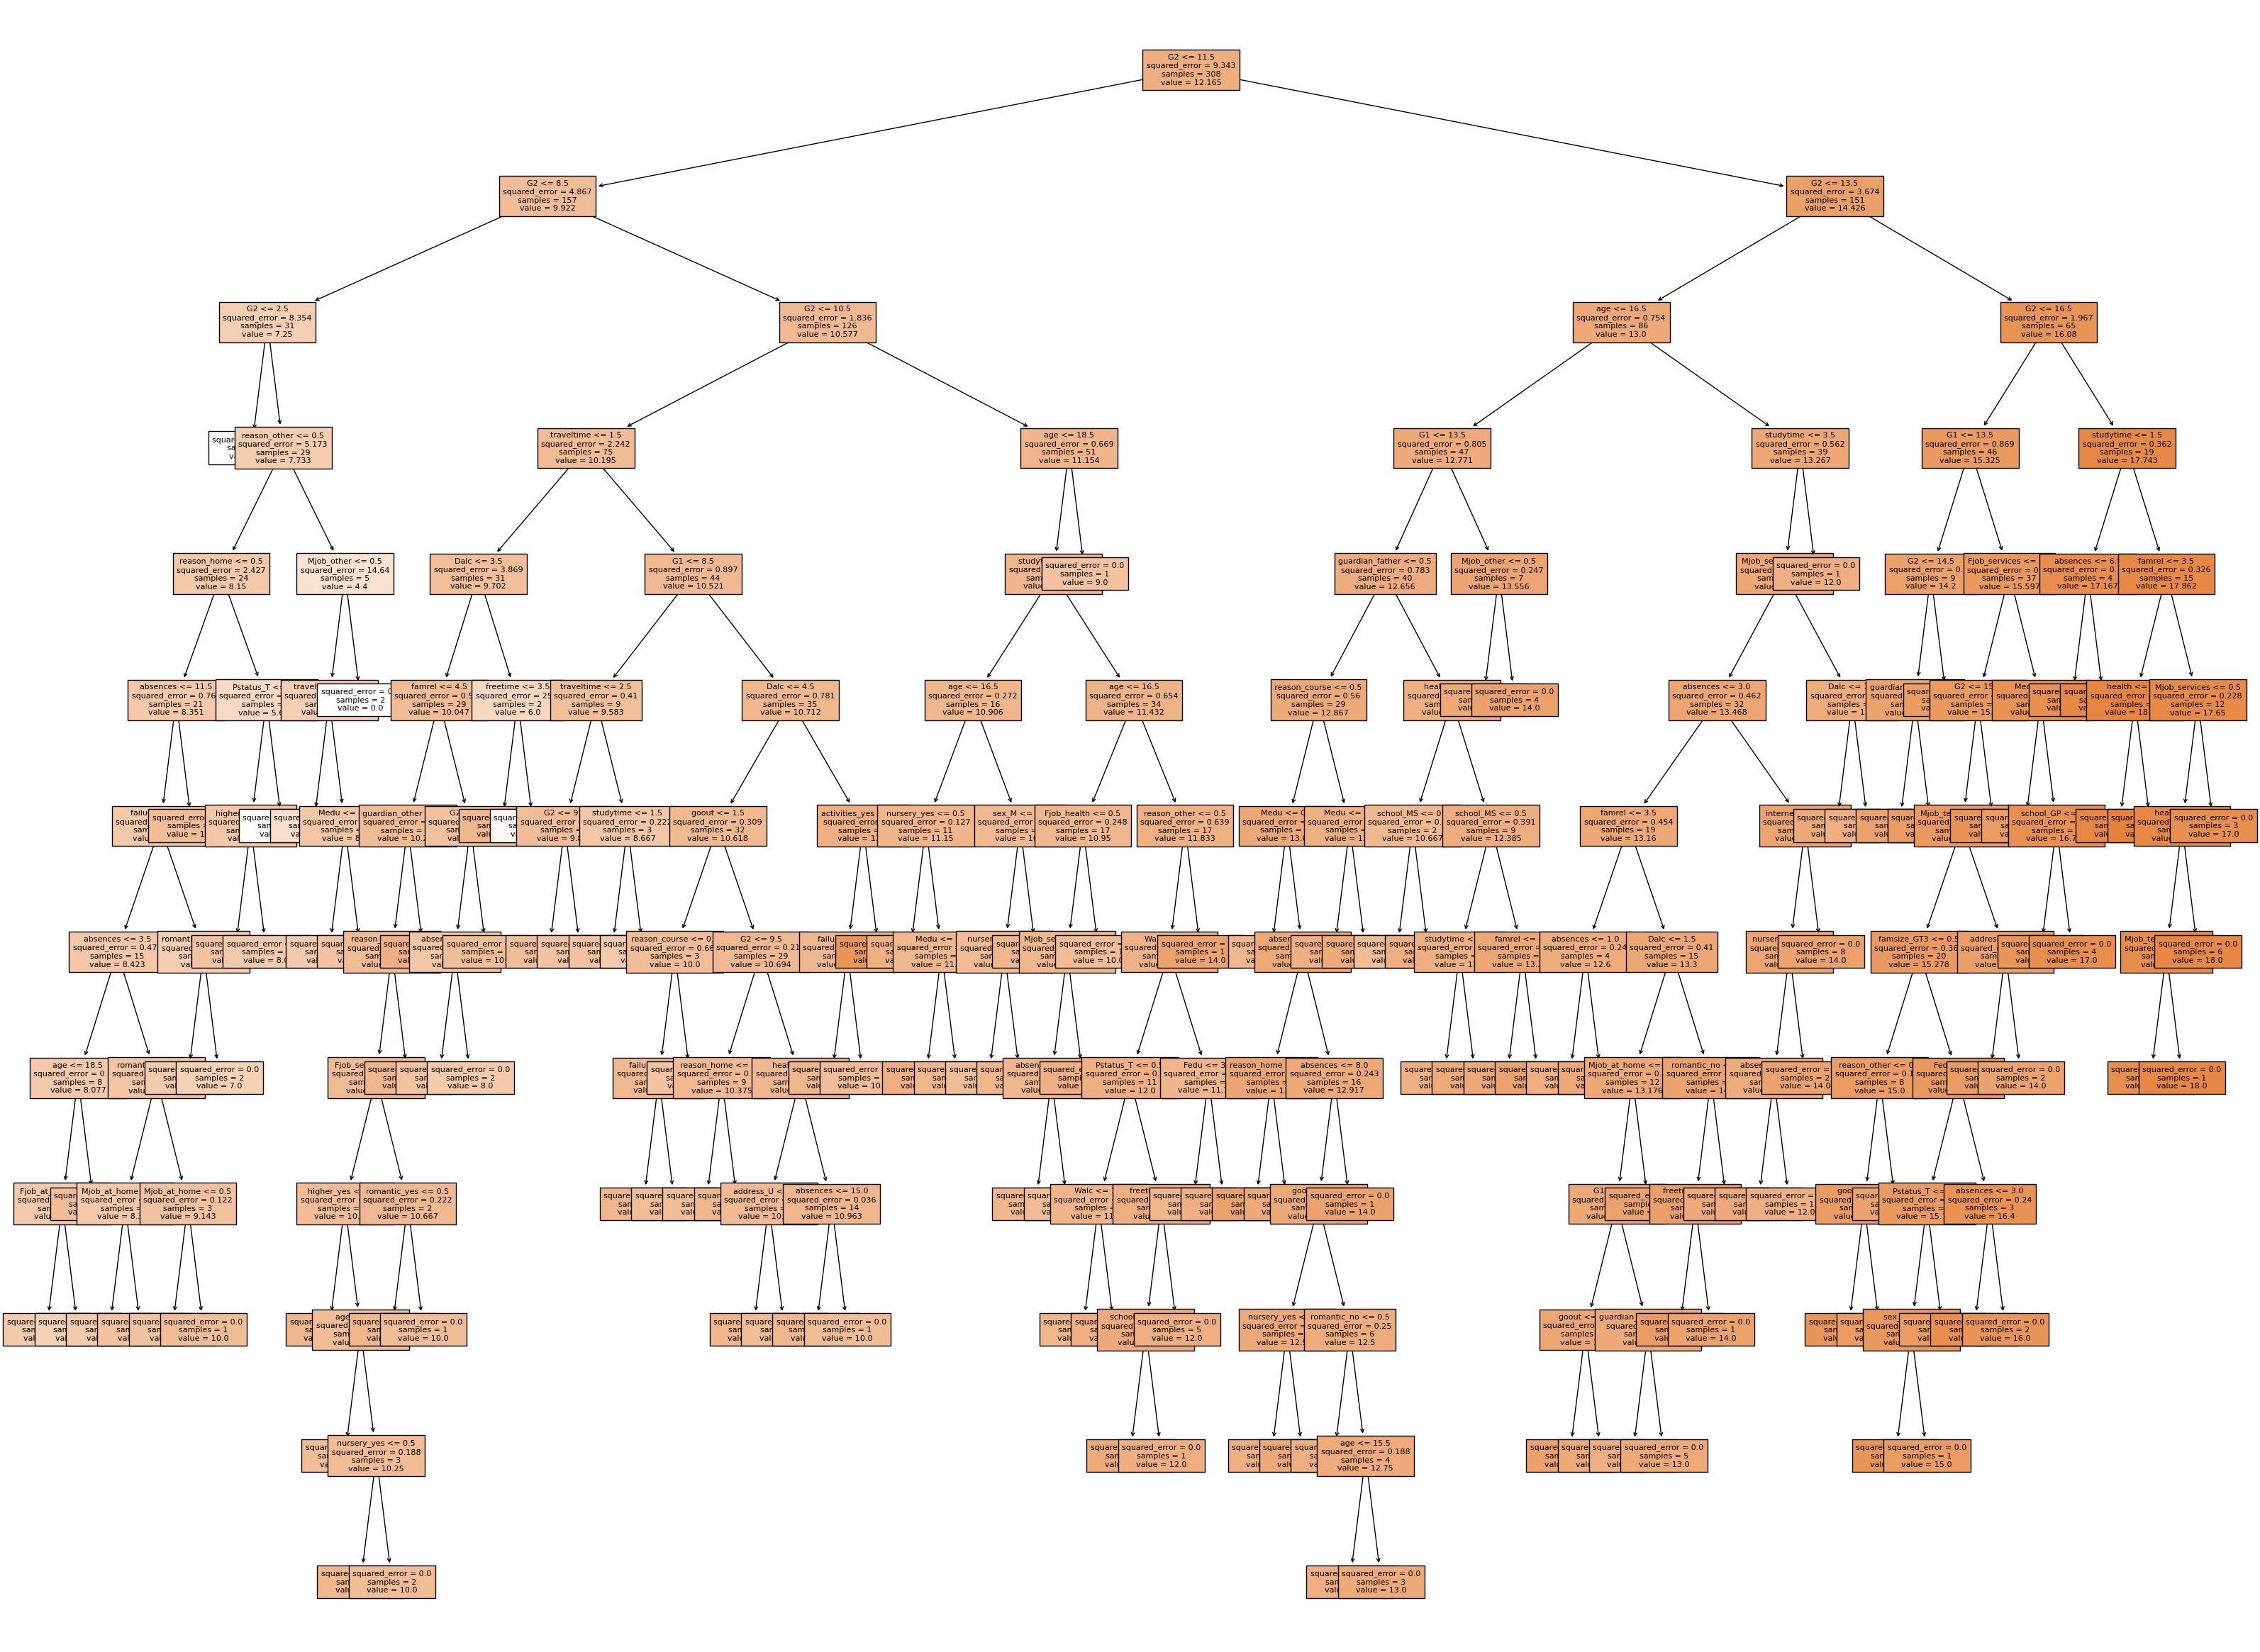

In [43]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(40,30))
plot_tree(example_tree, filled=True, feature_names=feature_names,ax=ax, fontsize=8);

In [44]:
# save the figure as a file first and open that manually
fig.savefig('example_tree.png',dpi=300)

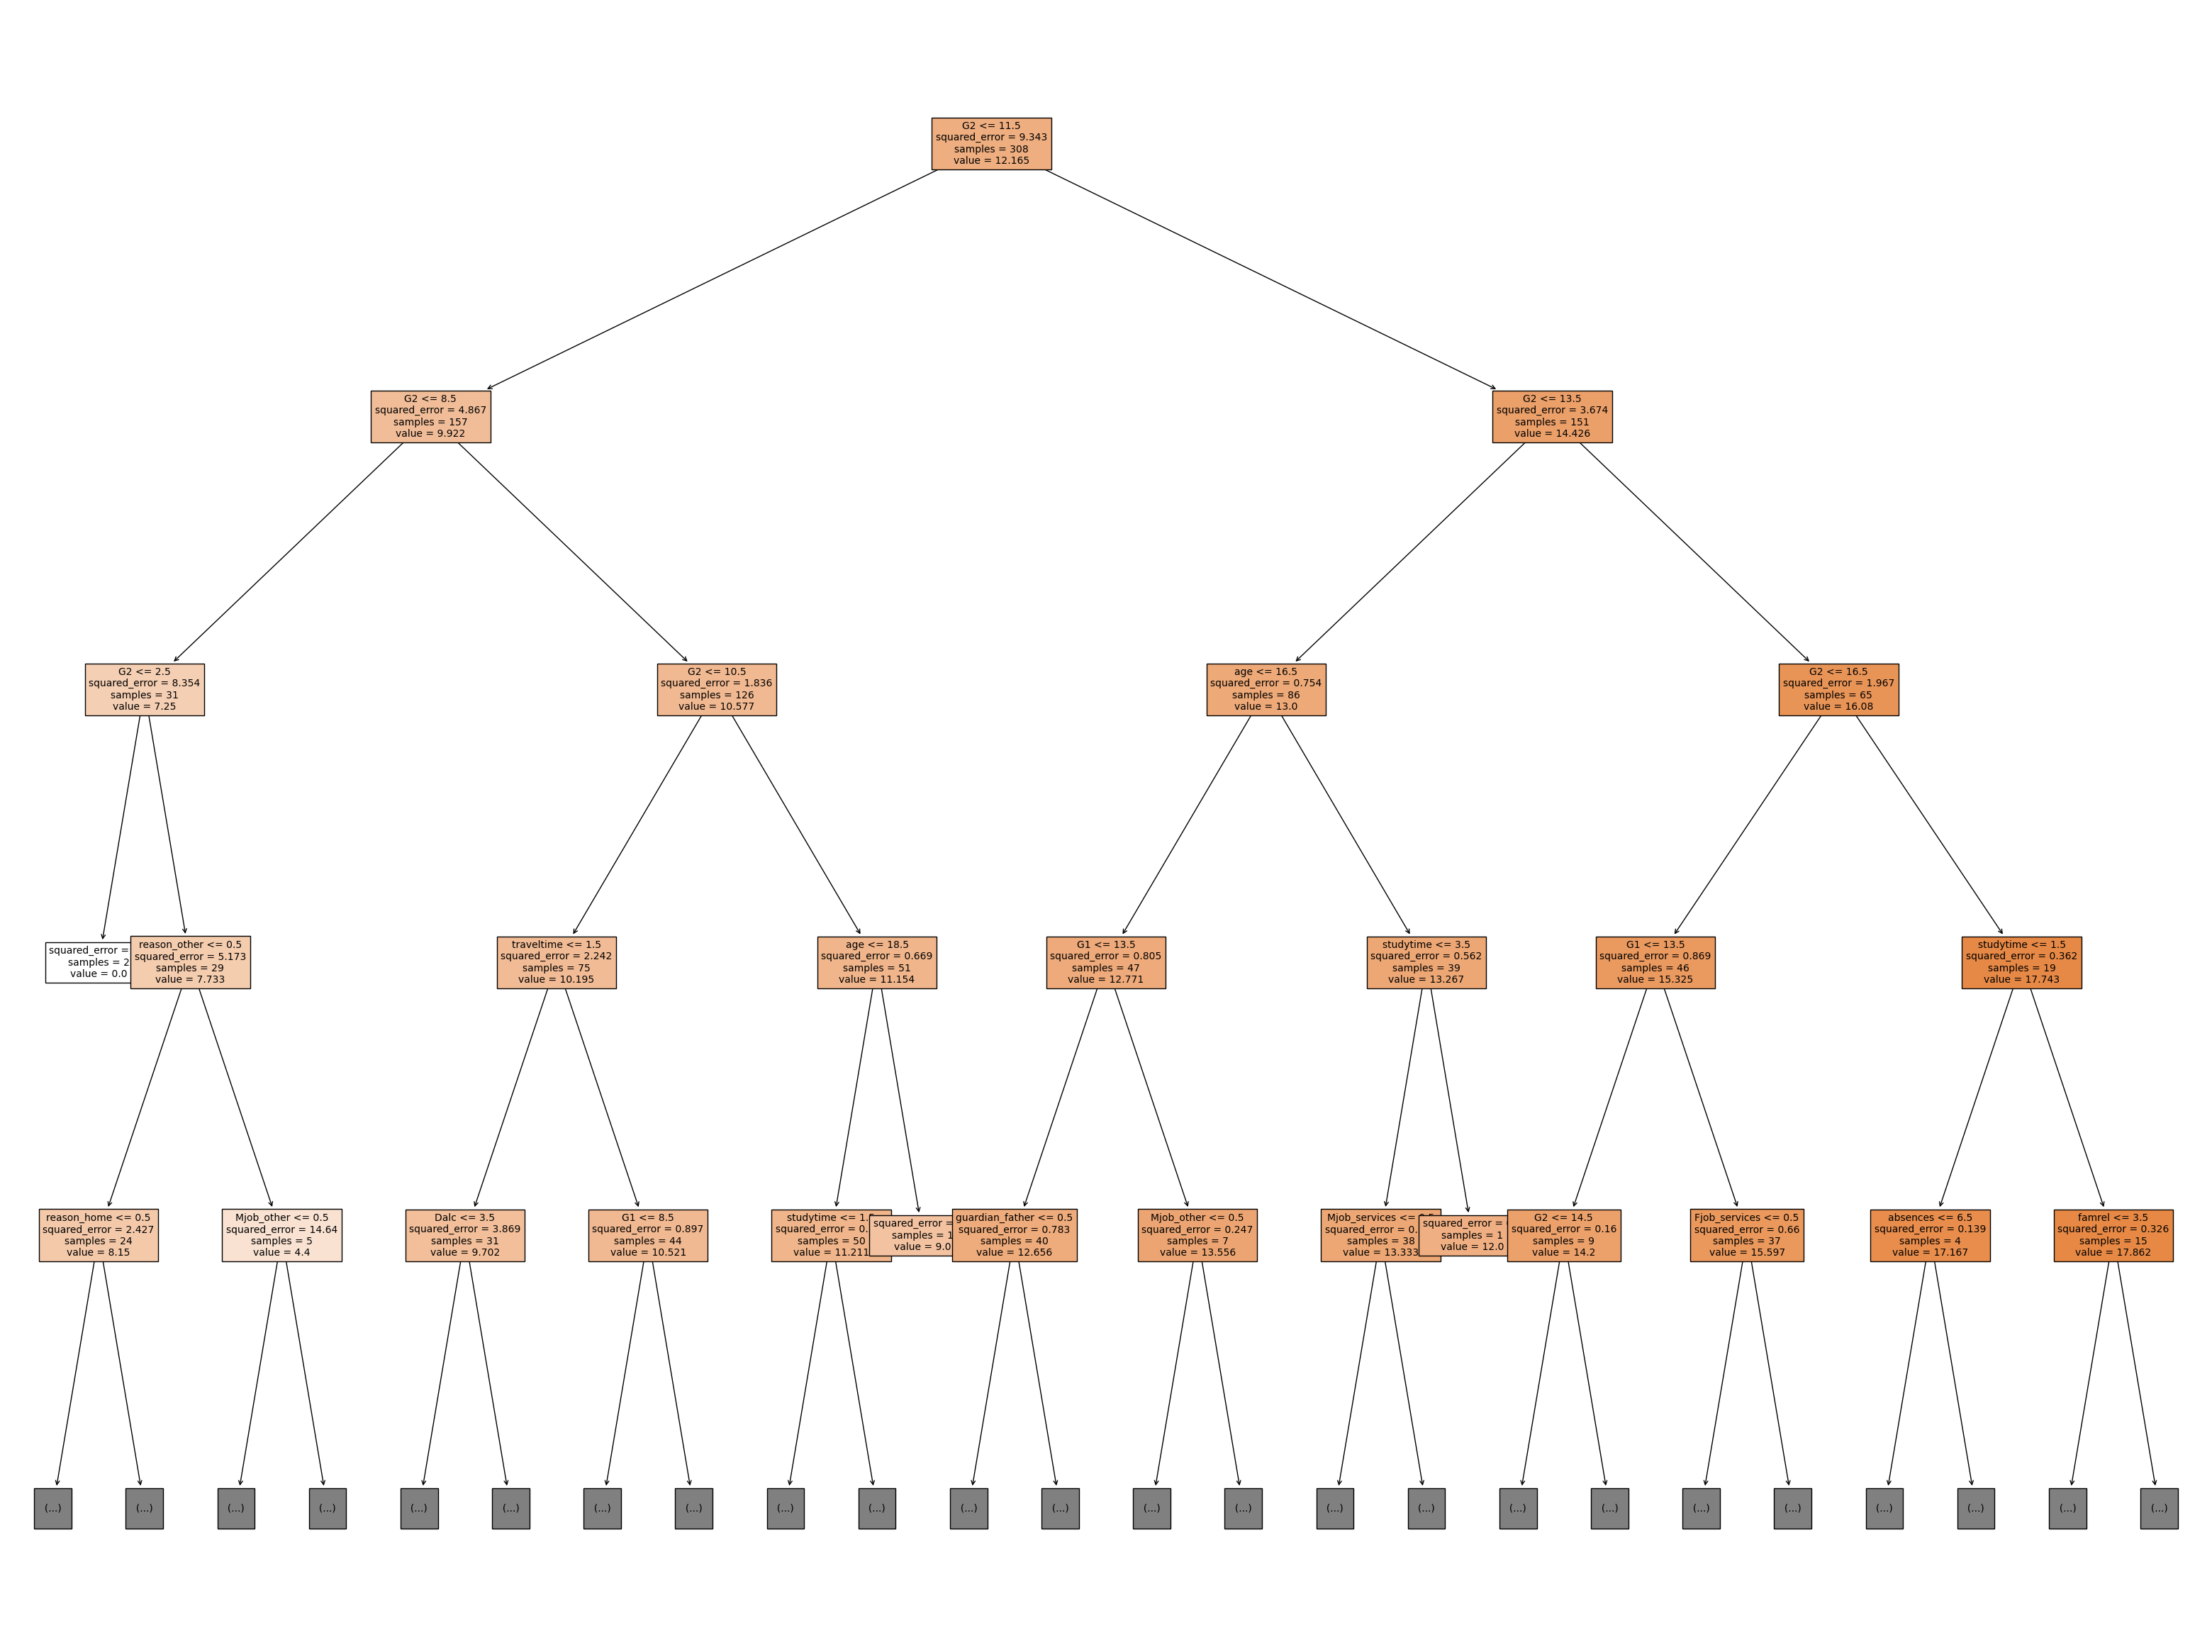

In [45]:
# inspect first few layers
fig, ax = plt.subplots(figsize=(40,30))
plot_tree(example_tree, max_depth=4,filled=True,feature_names=feature_names,ax=ax,
         fontsize=10);

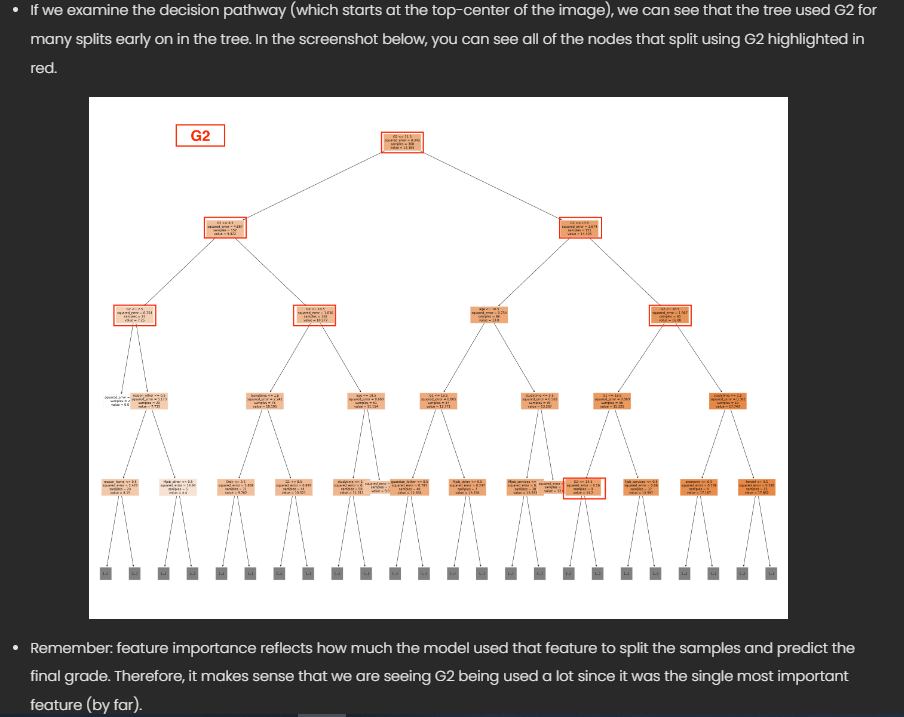

# Task B: Modeling Without Previous Grades

Our stakeholders do not want to wait until it is "too late" to start interventions with at-risk students. They want to make **identify the potential at-risk students BEFORE G1 and G2 grades are earned.** To address this, we will remove the G1 and G2 features in our next model to try to predict student grades for period 3 without knowing their prior grades.

In [46]:
## Drop the G1 and G2 features from the x vars
drop_cols = ['G1','G2']
X_train_B = X_train_df.drop(columns=drop_cols)
X_test_B = X_test_df.drop(columns=drop_cols)
feature_names_B = X_train_B.columns
X_train_B.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,Mjob_at_home,Mjob_health,...,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_no,schoolsup_yes,famsup_no,famsup_yes,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


Training Data:	R^2= 0.89	RMSE= 1.08
Test Data:	R^2= 0.35	RMSE= 2.44


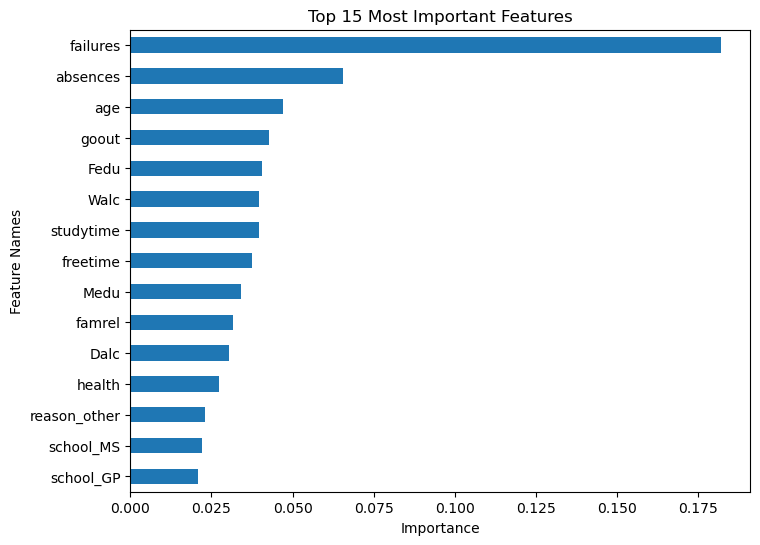

In [47]:
reg_B = RandomForestRegressor(random_state = SEED)
reg_B.fit(X_train_B, y_train)
evaluate_regression(reg_B, X_train_B, y_train, X_test_B,y_test)
## Saving the feature importances
importances = get_importances(reg_B, sort=True, ascending=False)
plot_importance(importances, top_n=15);

Now that we have removed G2 and G1, we see a couple of significant changes in our results:
- Our model's performance has decreased dramatically without those features. 
- Our testing R-squared plummeted from .71 to .35
- Many more features are showing visible degrees of importance than before.

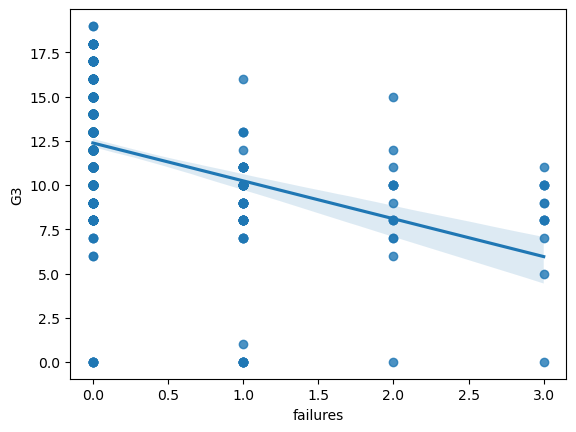

In [48]:
## Quick EDA For Top Features (without G1 & G2)
sns.regplot(data=plot_df, x='failures',y='G3');

As you can see, as students have more failures in other classes, they tend to have a lower scores in Portuguese, also.

In [49]:
from sklearn.inspection import permutation_importance
## Permutation importance takes a fit model and the test data.
r = permutation_importance(reg_B, X_test_B, y_test,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [50]:
##  pull out the importances_mean and make it a Pandas Series 
## so it is easy to work with.
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_B.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

failures             0.330172
studytime            0.031402
Dalc                 0.023881
absences             0.023429
goout                0.021416
famrel               0.015072
higher_no            0.015048
age                  0.015023
health               0.013105
higher_yes           0.011662
Medu                 0.011127
freetime             0.008297
sex_M                0.007310
famsup_yes           0.007219
traveltime           0.006336
schoolsup_no         0.005420
Walc                 0.005100
sex_F                0.005009
reason_other         0.004736
famsup_no            0.004639
schoolsup_yes        0.004422
Mjob_health          0.003891
address_U            0.003136
activities_yes       0.002400
reason_course        0.002150
Pstatus_T            0.002044
Mjob_other           0.001917
romantic_no          0.001792
guardian_father      0.001506
guardian_mother      0.001448
Mjob_teacher         0.001425
address_R            0.000692
internet_no          0.000482
Mjob_servi

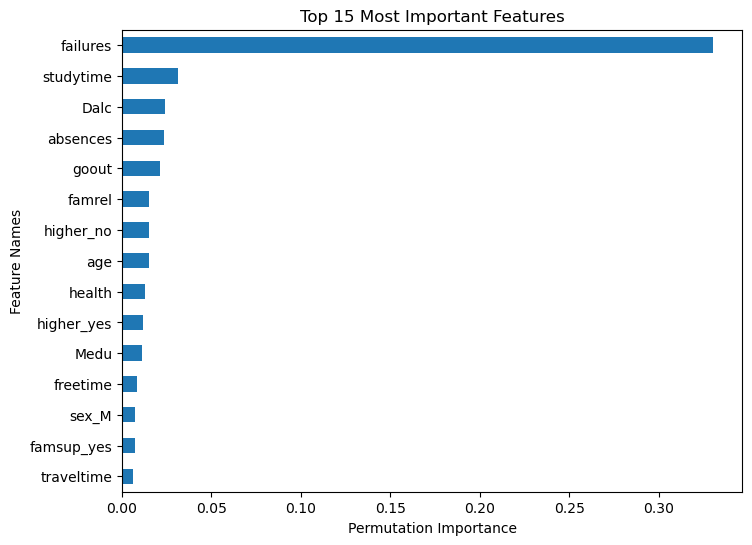

In [51]:
ax = plot_importance(permutation_importances,top_n=15)
ax.set(xlabel='Permutation Importance');

# What is different about the features valued by permutation importance vs the built-in feature importances?

To help us make the comparisons, we will update our visual with color.

Easier Comparisons - Color Coordination

We want to keep track of the top 5 important features from the random forest as we visualize the permutation importances.
We can do this by creating a dictionary with each feature name as the key and the corresponding color as the value.
So if we wanted to color code the top 5 features as green, we first need a list of those top 5 features, which we can get from the sorted importances.

In [52]:
## color -coding top 5 bars
highlight_feats = importances.sort_values(ascending=True).tail(5).index
highlight_feats

Index(['Fedu', 'goout', 'age', 'absences', 'failures'], dtype='object')

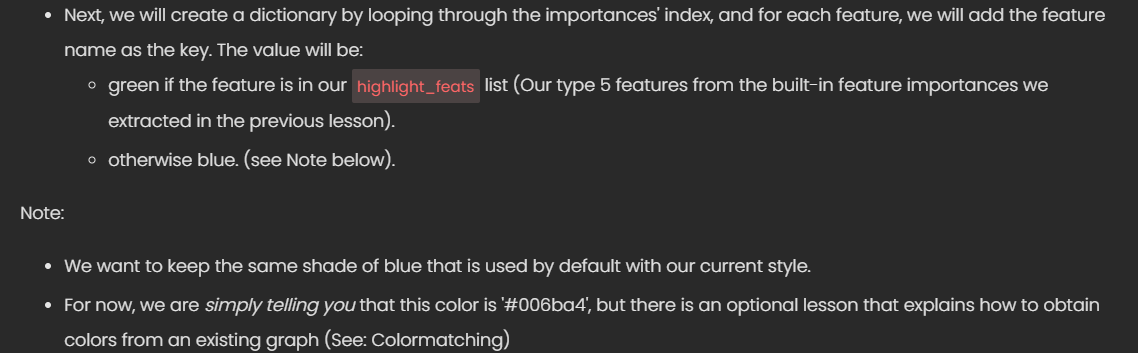

In [53]:
## create a dictionary of each feature and its color
colors_dict = {}
for col in importances.index:
    if col in highlight_feats:
        colors_dict[col] = 'green'    
    else:
        colors_dict[col] = '#006ba4'
colors_dict

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': '#006ba4',
 'studytime': '#006ba4',
 'freetime': '#006ba4',
 'Medu': '#006ba4',
 'famrel': '#006ba4',
 'Dalc': '#006ba4',
 'health': '#006ba4',
 'reason_other': '#006ba4',
 'school_MS': '#006ba4',
 'school_GP': '#006ba4',
 'traveltime': '#006ba4',
 'higher_no': '#006ba4',
 'Mjob_teacher': '#006ba4',
 'higher_yes': '#006ba4',
 'reason_home': '#006ba4',
 'schoolsup_no': '#006ba4',
 'reason_reputation': '#006ba4',
 'Fjob_teacher': '#006ba4',
 'schoolsup_yes': '#006ba4',
 'famsup_no': '#006ba4',
 'Fjob_services': '#006ba4',
 'Mjob_at_home': '#006ba4',
 'activities_yes': '#006ba4',
 'Mjob_other': '#006ba4',
 'reason_course': '#006ba4',
 'famsup_yes': '#006ba4',
 'Fjob_other': '#006ba4',
 'sex_M': '#006ba4',
 'activities_no': '#006ba4',
 'famsize_LE3': '#006ba4',
 'sex_F': '#006ba4',
 'Mjob_services': '#006ba4',
 'romantic_no': '#006ba4',
 'guardian_mother': '#006ba4',
 'nursery_yes': '

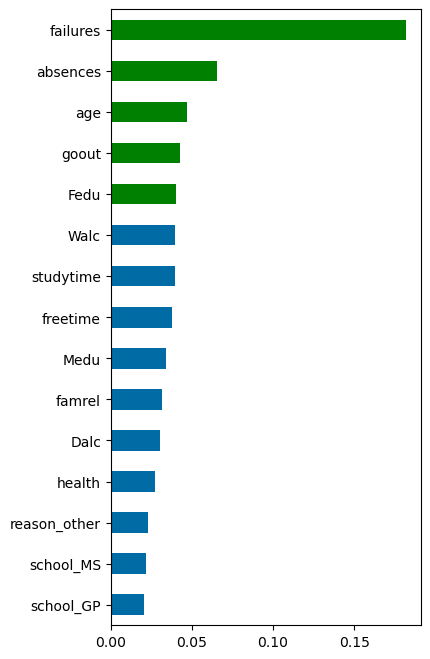

In [54]:
plot_vals = importances.sort_values().tail(15)
plot_vals.plot(kind='barh', color=plot_vals.index.map(colors_dict), figsize=(4,8));

In [55]:
#or create a custom function
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [56]:
colors_top7 = get_color_dict(importances, top_n=7)
colors_top7

{'failures': 'green',
 'absences': 'green',
 'age': 'green',
 'goout': 'green',
 'Fedu': 'green',
 'Walc': 'green',
 'studytime': 'green',
 'freetime': '#006ba4',
 'Medu': '#006ba4',
 'famrel': '#006ba4',
 'Dalc': '#006ba4',
 'health': '#006ba4',
 'reason_other': '#006ba4',
 'school_MS': '#006ba4',
 'school_GP': '#006ba4',
 'traveltime': '#006ba4',
 'higher_no': '#006ba4',
 'Mjob_teacher': '#006ba4',
 'higher_yes': '#006ba4',
 'reason_home': '#006ba4',
 'schoolsup_no': '#006ba4',
 'reason_reputation': '#006ba4',
 'Fjob_teacher': '#006ba4',
 'schoolsup_yes': '#006ba4',
 'famsup_no': '#006ba4',
 'Fjob_services': '#006ba4',
 'Mjob_at_home': '#006ba4',
 'activities_yes': '#006ba4',
 'Mjob_other': '#006ba4',
 'reason_course': '#006ba4',
 'famsup_yes': '#006ba4',
 'Fjob_other': '#006ba4',
 'sex_M': '#006ba4',
 'activities_no': '#006ba4',
 'famsize_LE3': '#006ba4',
 'sex_F': '#006ba4',
 'Mjob_services': '#006ba4',
 'romantic_no': '#006ba4',
 'guardian_mother': '#006ba4',
 'nursery_yes': '#006

In [57]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

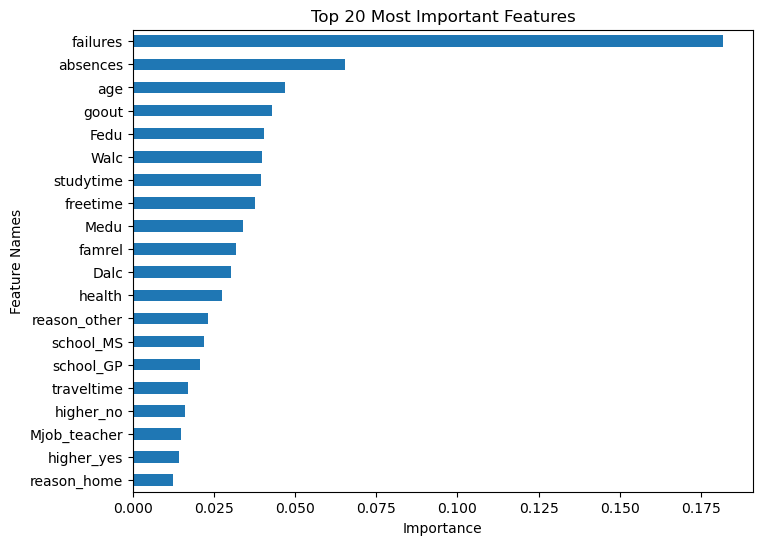

In [58]:
plot_importance_color(importances, color_dict=None,top_n=20);

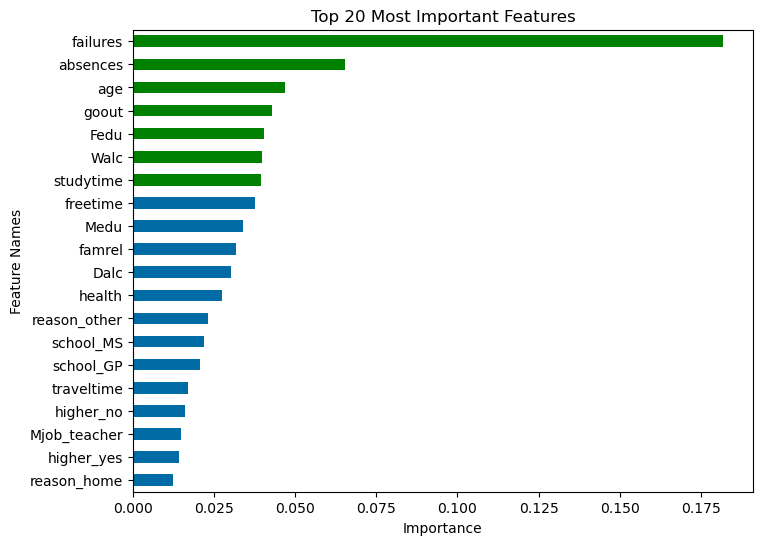

In [59]:
plot_importance_color(importances, color_dict=colors_top7,top_n=20);

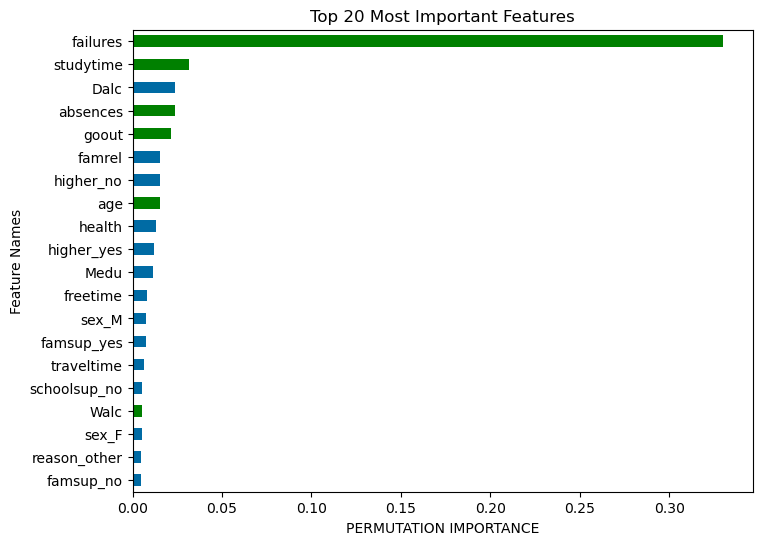

In [60]:
# let's plot based on the order of permutation importance.
ax = plot_importance_color(permutation_importances,color_dict=colors_top7,top_n=20);
ax.set_xlabel("PERMUTATION IMPORTANCE");

Now you can see the benefit of color coding. We see that there is some overlap between important features and also some key differences.

The function below will create both a plot of built-in feature importance and permutation importance side by side for easy comparison.

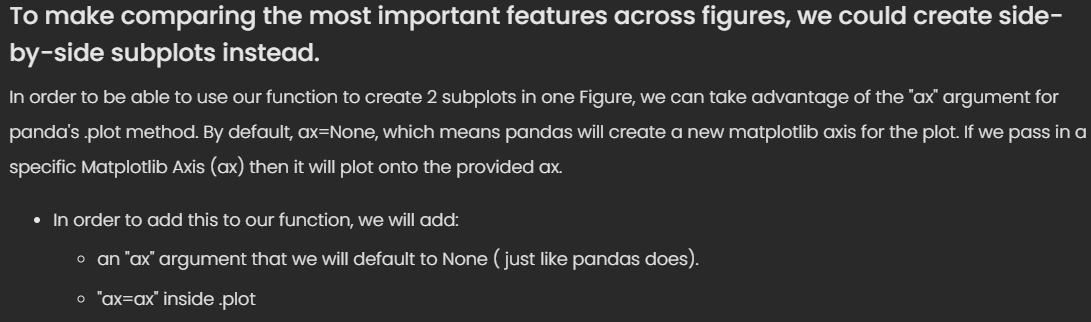

In [61]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

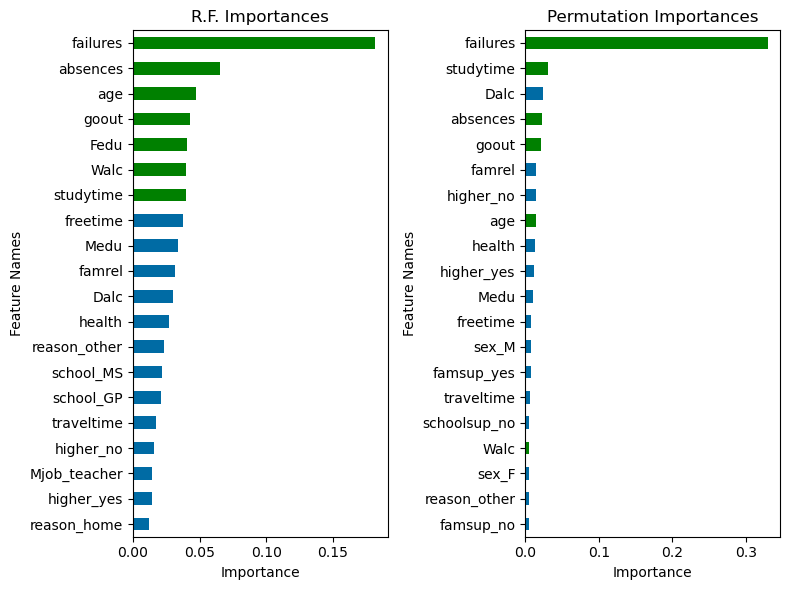

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
n = 20 # setting the # of features to use for both subplots
plot_importance_color_ax(importances, top_n=n, ax=axes[0],
                         color_dict= colors_top7)
plot_importance_color_ax(permutation_importances, top_n=n, ax=axes[1],
                         color_dict=colors_top7)
axes[0].set(title='R.F. Importances')
axes[1].set(title='Permutation Importances')
fig.tight_layout()


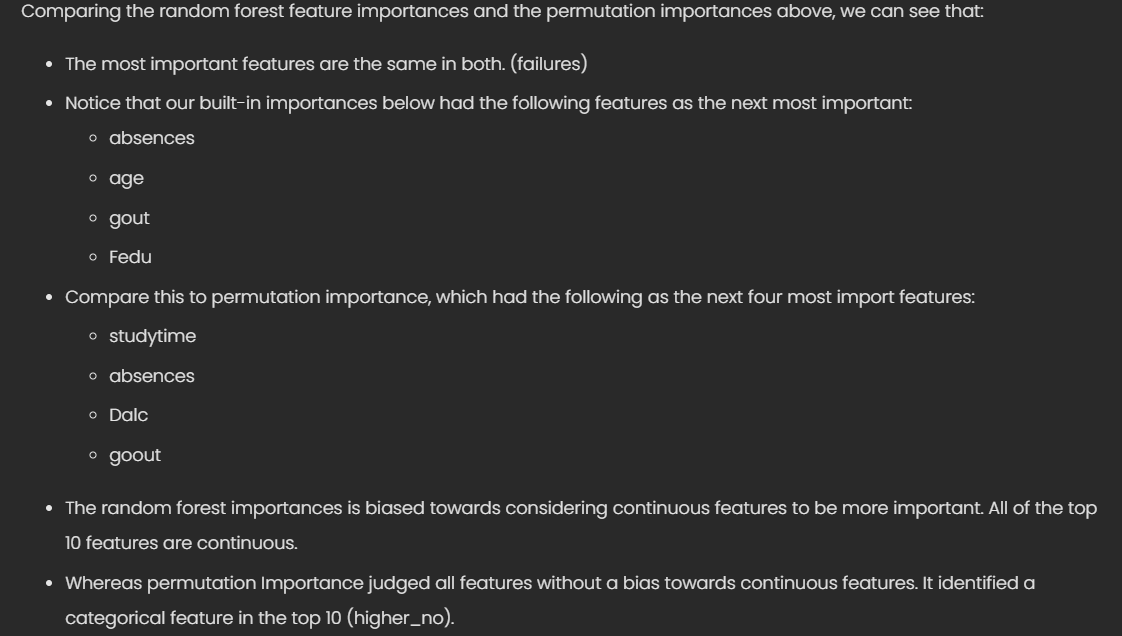

## Advantages/Disadvantages of Permutation Importance
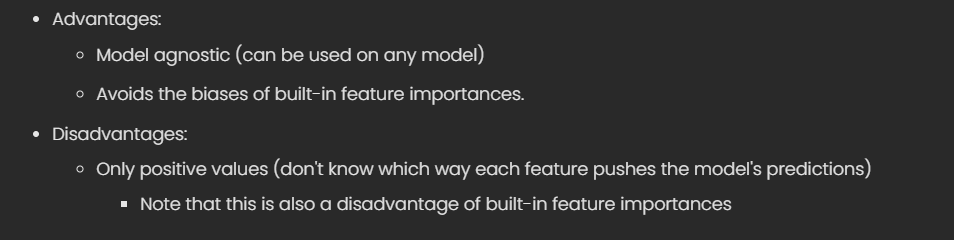

## EDA Follow-Up
Now that we have some categorical features appearing in our permutation importances, let's try to visualize those.
We will want to return to the original dataframe that still had the categorical features as a single column.

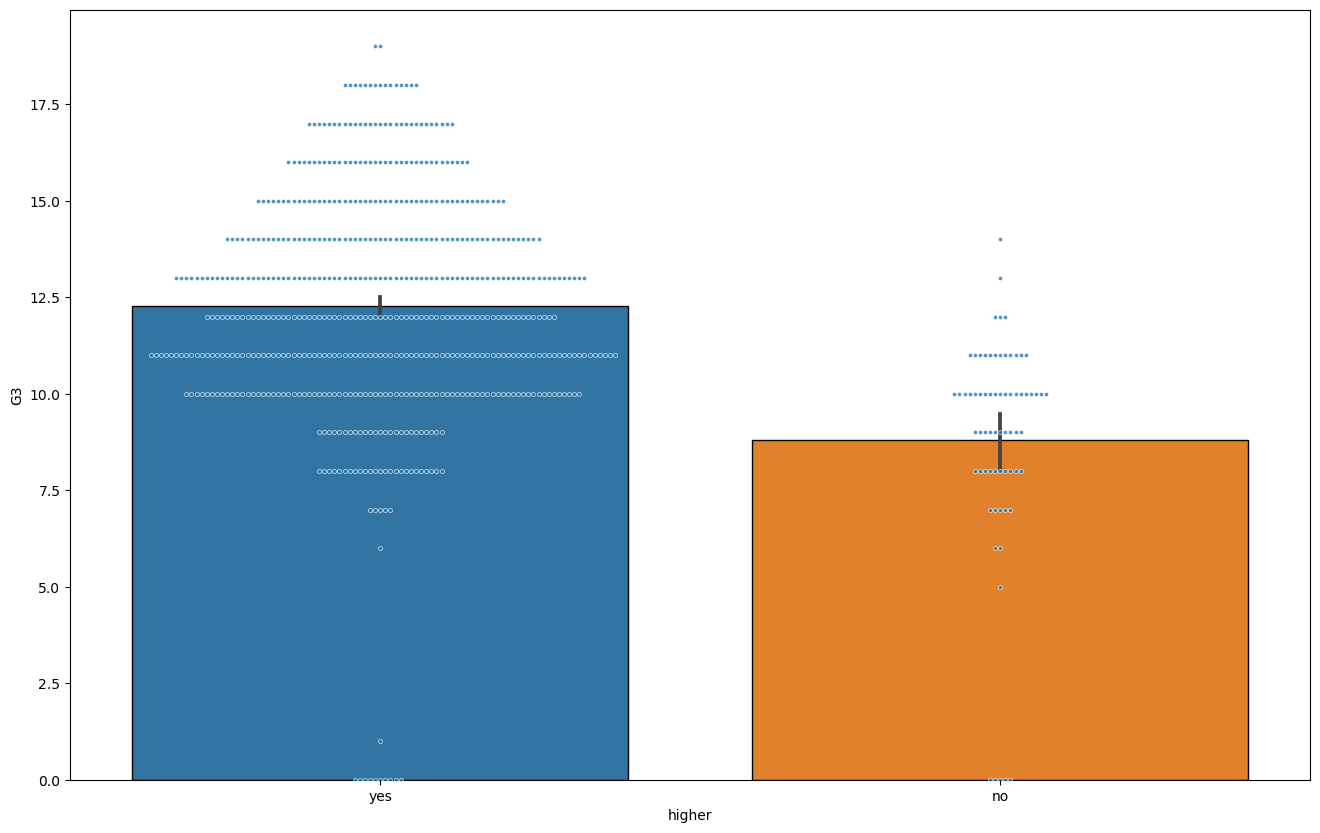

In [63]:
plt.figure(figsize=(16,10))
sns.swarmplot(data=df, x='higher',y='G3',size=3,edgecolor='white',
              linewidth=0.5, alpha=.8);
sns.barplot(data=df, x='higher',y='G3',edgecolor='black',
            linewidth=1);